In [1]:
%matplotlib widget

# DEFAULTS

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
from tqdm import tqdm
from scipy.integrate import simpson
import sys
sys.path.append("..")
from truncation import get_truncation


FORCES = ["LO", "NLO", "N2LO", "N3LO", "N4LO", "N4LO+"]
CUTOFF = [400, 450, 500, 550]

# plt.style.use(['science', 'retro'])

mpl.rcParams['mathtext.fontset'] = 'custom'
mpl.rcParams['mathtext.rm'] = 'DejaVu Sans'
mpl.rcParams['mathtext.it'] = 'DejaVu Sans:italic'
mpl.rcParams['mathtext.bf'] = 'DejaVu Sans:bold'

plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.sans-serif"] = "DejaVu Sans"

# plt.rc('text', usetex=False)
plt.rc('text', usetex=True)
plt.rcParams['axes.linewidth'] = 1.2
mpl.rcParams['lines.linewidth'] = 2

line_styles = {"LO": {"marker": "d", "markevery": 10, "markersize": 3, "color": "tab:cyan"},
               "NLO": {"marker": ".", "markevery": 10, "color": "orange"},
               "N2LO": {"ls":  (0, (5, 3)), "color": "green"},
               "N3LO": {"ls": "dotted", "color": "blue"},
               "N4LO": {"ls": (0, (5, 2, 0.8, 2, 0.8, 2)), "color": "red"},
               "N4LO+": {"color": "black"},
               "AV18": {"ls": (0, (5, 2, 1.3, 2,)), "color": "blueviolet"},
               "SIEGERT": {"color": "blue"},
               "1NC": {"color": "deeppink", "ls": "dashed"}
               }
ls_cutoff = {400: line_styles["N4LO"],
             450: line_styles["N4LO+"],
             500: line_styles["N2LO"],
             550: line_styles["N3LO"],
             }

exp_style = [
    {"fmt": "ok"},
    {"fmt": "ok", "markerfacecolor": "None", "markeredgecolor": "k"},
    {"fmt": "sk"},
    {"fmt": "^k"},
    {"fmt": "Xk"},
    {"fmt": "dk"},
]

trunc_colors = {
    "NLO": "bisque",
    "N2LO": "limegreen",
    "N3LO": "dodgerblue",
    "N4LO": "red",
    "N4LO+": "black",
}

marker_common = {"markersize": 6, "elinewidth": 0.9, "capsize": 2.5}


df_my = pd.read_csv("./deuteron_all_data.csv")
df_my.T21D2 *= 2
df_my.T22D2 *= 2
df_my.T21D *= 2
df_my.T22D *= 2
df_my.AX *= -1
df_my.AX2 *= -1

df_neuteron = pd.read_csv("./neuteron_Detected_data_2p75mev.csv")
df_neuteron.T21D2 *= 2
df_neuteron.T22D2 *= 2
df_neuteron.T21D *= 2
df_neuteron.T22D *= 2
df_neuteron.AX *= -1
df_neuteron.AX2 *= -1

OBSERVABLES = [ob for ob in df_my.columns.values if ob not in [
    "THCM", "angle", "CUTOFF", "FORCE"]]

my_energies = df_my.Energy.unique()
my_energies.sort()

In [22]:
df_jewell = pd.read_csv("./ExpData/PolarizationNeuteron/Jewell1965.dat")

/home/vitalii/anaconda3/envs/experimental/lib/python3.9/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
/tmp/ipykernel_9692/2522405157.py:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(5, 8.4))


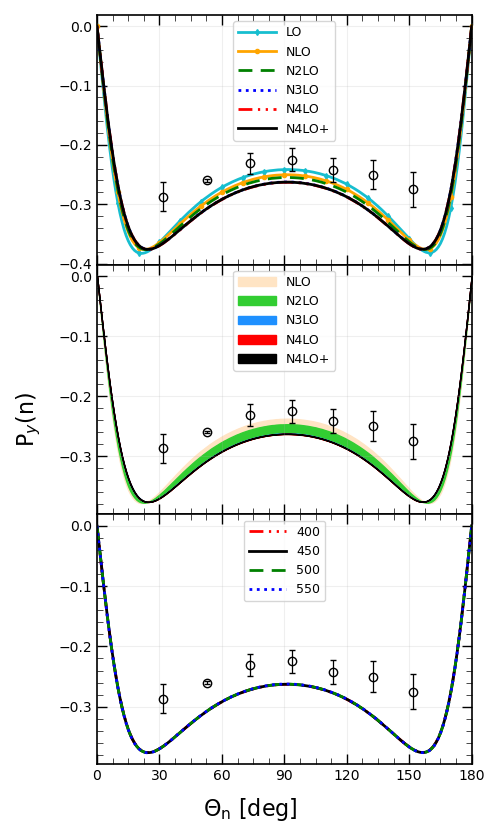

In [48]:
obs = "POLNOUT2(y)"
energy=2.75
cutoff=450
df=df_neuteron
wave="SIEGERT"
ylabel="P$_y$(n)"
df_tmp = df[(df.CUTOFF == cutoff) &
            (df.WAVE == wave)]
df_tmp.sort_values("angle", inplace=True)
df_piv = df_tmp.pivot(index="angle", columns="FORCE")[obs].reindex(FORCES, axis=1)
df_trunc = get_truncation(df_piv, energy)

fig = plt.figure(figsize=(5, 8.4))
gs = fig.add_gridspec(nrows=3, hspace=0)
axes = gs.subplots(sharex=True)
fig.supxlabel("$\Theta_\mathrm{n}$ [deg]", y=0.02, size=16)
if not ylabel:
    ylabel = obs
fig.supylabel(ylabel, x=0.03, size=16)
for force in FORCES:
    df_tmp = df[(df.FORCE == force) &
                (df.CUTOFF == cutoff) &
                # (df.Energy == energy) &
                (df.WAVE == "SIEGERT")]
    axes[0].plot(df_tmp.angle, df_tmp[obs],
                **line_styles[force], label=force)
    if force != "LO":
        axes[1].fill_between(df_tmp.angle, df_tmp[obs].values+df_trunc[force].values,
                            df_tmp[obs].values-df_trunc[force].values, label=force,
                            color=trunc_colors[force])
    # break
for cut in CUTOFF:
    df_tmp = df[(df.FORCE == "N4LO+") &
                (df.CUTOFF == cut) &
                # (df.Energy == energy) &
                (df.WAVE == "SIEGERT")]
    # print(df_tmp.head())
    axes[2].plot(df_tmp.angle, df_tmp[obs],
                **ls_cutoff[cut], label=cut)
# df_av18 = df[(df.FORCE == "AV18") & (df.Energy == energy)]
for j, ax in enumerate(axes):
    ax.errorbar(df_jewell.Theta, df_jewell["P(n)"],
                yerr=df_jewell.Error, zorder=3, **exp_style[1], **marker_common)
                    # , label=df_tmp.fname[0])
    # if j != 1:
    #     ax.plot(df_av18.angle, df_av18[obs],
    #             **line_styles["AV18"], label="AV18")

    ax.legend(fontsize=9, handlelength=3, loc="upper center")
    
    ax.xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator())
    ax.yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator())
    ax.tick_params(which='minor', direction='in', length=4,
                width=0.5, top=True, right=True)
    ax.tick_params(which='major', direction='in',
                length=7, width=1, top=True, right=True, zorder=1)
    ax.set_xticks(np.arange(0, 180+j-1, 30))
    ax.set_xlim([0, 180])
    ax.grid(alpha=0.2)
    ax.set_zorder(-1)
fig.tight_layout()
plt.savefig(f"../Figures_De/{obs}_{energy}mev_neuteron.pdf",
            dpi=600, facecolor="white")

# Proton polarization

In [3]:
def make_fig(obs, energy, cutoff, df, exp=None, wave="SIEGERT", ylabel=None, save=True):
    df_tmp = df[(df.CUTOFF == cutoff) &
                (df.Energy == energy) &
                (df.WAVE == wave)]
    df_tmp.sort_values("angle", inplace=True)
    df_piv = df_tmp.pivot(index="angle", columns="FORCE")[
        obs].reindex(FORCES, axis=1)
    df_trunc = get_truncation(df_piv, energy)

    fig = plt.figure(figsize=(5, 8.4))
    gs = fig.add_gridspec(nrows=3, hspace=0)
    axes = gs.subplots(sharex=True)
    fig.supxlabel("$\Theta_\mathrm{p}$ [deg]", y=0.02, size=16)
    if not ylabel:
        ylabel = obs
    fig.supylabel(ylabel, x=0.03, size=16)
    for force in FORCES:
        df_tmp = df[(df.FORCE == force) &
                    (df.CUTOFF == cutoff) &
                    (df.Energy == energy) &
                    (df.WAVE == "SIEGERT")]
        axes[0].plot(df_tmp.angle, df_tmp[obs],
                     **line_styles[force], label=force)
        if force != "LO":
            axes[1].fill_between(df_tmp.angle, df_tmp[obs].values+df_trunc[force].values,
                                 df_tmp[obs].values-df_trunc[force].values, label=force,
                                 color=trunc_colors[force])
        # break
    for cut in CUTOFF:
        df_tmp = df[(df.FORCE == "N4LO+") &
                    (df.CUTOFF == cut) &
                    (df.Energy == energy) &
                    (df.WAVE == "SIEGERT")]
        axes[2].plot(df_tmp.angle, df_tmp[obs],
                     **ls_cutoff[cut], label=cut)
    df_av18 = df[(df.FORCE == "AV18") & (df.Energy == energy)]
    for j, ax in enumerate(axes):
        if j != 1:
            ax.plot(df_av18.angle, df_av18[obs],
                    **line_styles["AV18"], label="AV18")
        # style
        # tmp
        # if j == 1:
        #     ax.legend(fontsize=9, handlelength=3, loc="upper center")
        # else:
        #     ax.legend(fontsize=9, handlelength=3, loc="best")
        ax.legend(fontsize=9, handlelength=3, loc="best")

        ax.xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator())
        ax.yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator())
        ax.tick_params(which='minor', direction='in', length=4,
                       width=0.5, top=True, right=True)
        ax.tick_params(which='major', direction='in',
                       length=7, width=1, top=True, right=True, zorder=1)
        ax.set_xticks(np.arange(0, 180+j-1, 30))
        ax.set_xlim([0, 180])
        ax.grid(alpha=0.2)
        ax.set_zorder(-1)
    fig.tight_layout()
    if save:
        plt.savefig(f"../Figures_De/{obs}_{energy}mev.pdf",
                    dpi=600, facecolor="white")
    return ax, fig


In [5]:
from io import StringIO

In [6]:
data="""18.88483234992566, 0.06922707224664267
30.59569104790353, 0.06461113120430668
36.28908294875143, 0.06194432722108674
24.176707234875295, 0.06776121804042586
13.82358819617636, 0.05675468300658487
41.660978397356075, 0.050727116311766865
10.845649773065901, 0.04109453968013543
6.656471433016463, 0.02812197613159692
48.412335127984704, 0.025915434467436216
4.311728810080979, 0.014632714397136426
52.528307679036715, 0.010788313221188062
-0.16199503502596713, 0.006023716189532596
58.16984522852067, -0.006504642655752152
178.04153661152628, -0.022226526747636532
62.60187085660064, -0.023791383956346
176.98921233912824, -0.03931583438672201
67.03301603454084, -0.04179745278192307
175.99164711926065, -0.05352406531586293
70.81661596697711, -0.05836153036667549
74.76177527102172, -0.07924243035025436
80.92357723027187, -0.1029741882482974
82.67120976478557, -0.11442757837591272
85.46676425606074, -0.1292080110455977
88.34125293399025, -0.14270933411045805
167.61665893876645, -0.15309139571270908
90.72146605147918, -0.1598896220819459
166.31220783482226, -0.16890999840453208
93.63326463433783, -0.17501055617871075
163.84085533132472, -0.18472260545653718
96.36040267327517, -0.18977087544930255
163.60399486952508, -0.20054669352095955
98.57286043965769, -0.20596721434598275
161.9891976486784, -0.21636370162772467
102.09964088777033, -0.2210913082724984
103.70412636555818, -0.23145793375986018
160.39922811718395, -0.23218083730129435
105.55726755508059, -0.24573236321906233
158.8154655080275, -0.2479980048665652
107.10223013797025, -0.25636428239838255
157.05170215106764, -0.2638142475725025
154.69664991147874, -0.2746720536267913
111.39831734999578, -0.2779663175285664
153.70848874024054, -0.28969302361149635
116.46577790816931, -0.30101098013901295
151.1626531686864, -0.30550524796308753
120.0632954450527, -0.3168547695675904
148.2630230238634, -0.3213156544877127
126.60608864228291, -0.33141889438812855
122.52194378973205, -0.3276573830465611
144.54384233453678, -0.3364025180422955
128.59909019639684, -0.3442332450704875
140.45082552964053, -0.34717146850187214
134.00015053452444, -0.3514543166714541
169.64224370862945, -0.13532402556380657
171.21412859538603, -0.11036100377773983
173.3136285332271, -0.08817525939720211"""

In [8]:
df_arenh = pd.read_csv(StringIO(data), sep=", ", names=["x", "y"])

/tmp/ipykernel_2098176/2820086148.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df_arenh = pd.read_csv(StringIO(data), sep=", ", names=["x", "y"])


/tmp/ipykernel_2098176/3814489160.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tmp.sort_values("angle", inplace=True)
/home/vitalii/Jagielllonian_work/THESIS/thesis/PlotData/Deuteron/../truncation.py:65: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  maxdiff.append(df_diff[FORCES[force_num-1]]*EPSILON)
/home/vitalii/Jagielllonian_work/THESIS/thesis/PlotData/Deuteron/../truncation.py:65: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  maxdiff.append(df_diff[FORCES[force_num-1]]*EPSILON)
/home/vitalii/Jagielllonian_work/THESIS/thesis/PlotData/Deuteron/../truncation.py:65: FutureWarning: The series.append method is deprec

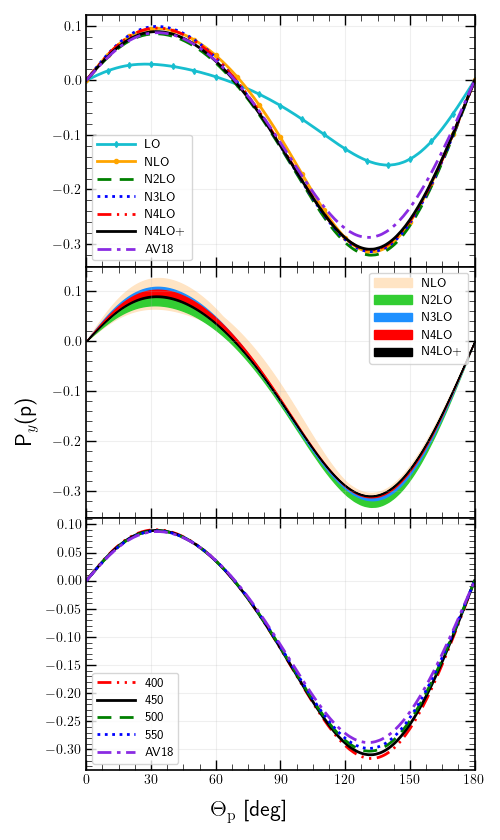

In [4]:
ax, fig = make_fig("POLNOUT2(y)", 100, 450, df_my, save=False,
                   ylabel="P$_y$(p)")


In [49]:
df_cameron=pd.read_csv("ExpData/Capture_analyzing/cameron.dat")

In [50]:
df_tmp = pd.read_csv("../../../test/2.dat5.5.2.100mev_neuteron", skiprows=1, delim_whitespace=True,
                     names=["THCM", "CROSSCAP", "CROSSCAP2", "AYN1CAP", "AYN1CAP2"])


In [9]:
df_tmp2 = df_my[(df_my.FORCE == "N4LO+") &
                    (df_my.CUTOFF == 450) &
                    (df_my.Energy == 100) &
                    (df_my.WAVE == "SIEGERT")]

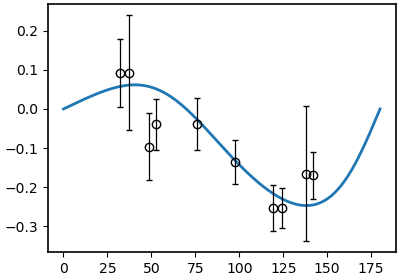

In [51]:
fig, ax = plt.subplots(1, 1, figsize=(4, 2.8), constrained_layout=True)
ax.plot(df_tmp.THCM*180/np.pi, -df_tmp["AYN1CAP2"])
ax.plot(df_tmp2.THCM*180/np.pi, -df_tmp2["AYN1CAP2"])
ax.errorbar(df_cameron.theta, df_cameron.Ay,
            yerr=df_cameron["Ay-error"], zorder=3, **exp_style[1], **marker_common)
plt.show()


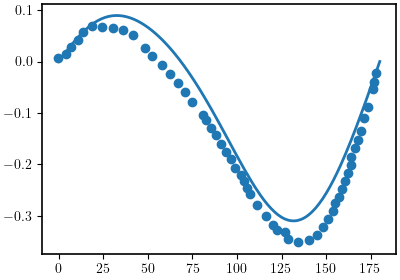

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(4, 2.8), constrained_layout=True)
ax.plot(df_tmp2.angle, df_tmp2["POLNOUT2(y)"])
ax.scatter(df_arenh.x, df_arenh.y)
# ax.plot(df_tmp2.THCM*180/np.pi, -df_tmp2["AYN1CAP2"])
# ax.errorbar(df_cameron.theta, df_cameron.Ay,
#             yerr=df_cameron["Ay-error"], zorder=3, **exp_style[1], **marker_common)
plt.show()
